In [2]:
import easyocr
import cv2
import random
import numpy as np
import imutils
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# easyocr
reader = easyocr.Reader(['ru'])


In [4]:
detections = [{
    'bboxes': [
    [
        1857, 356, 1857, 362, 1855, 364, 1824, 364, 1824, 371, 1822, 373, 1808,
        373, 1808, 379, 1806, 381, 1783, 381, 1783, 388, 1781, 390, 1758, 390,
        1758, 396, 1756, 398, 1750, 398, 1750, 426, 1768, 426, 1768, 419, 1771,
        417, 1793, 417, 1793, 411, 1795, 409, 1810, 409, 1810, 402, 1812, 400,
        1835, 400, 1835, 394, 1837, 392, 1860, 392, 1860, 386, 1862, 383, 1884,
        383, 1884, 356
    ],
               [
                   1684, 466, 1684, 472, 1682, 474, 1659, 474, 1659, 480, 1657,
                   483, 1634, 483, 1634, 489, 1632, 491, 1609, 491, 1609, 527,
                   1628, 527, 1628, 521, 1630, 518, 1661, 518, 1661, 512, 1663,
                   510, 1694, 510, 1694, 504, 1696, 502, 1719, 502, 1719, 466
               ],
               [
                   1800, 561, 1800, 567, 1797, 569, 1775, 569, 1775, 588, 1851,
                   588, 1851, 582, 1853, 580, 1860, 580, 1860, 561
               ],
               [
                   1642, 577, 1642, 584, 1640, 586, 1617, 586, 1617, 592, 1615,
                   594, 1601, 594, 1601, 618, 1603, 618, 1605, 620, 1605, 639,
                   1632, 639, 1632, 637, 1634, 634, 1644, 634, 1644, 632, 1646,
                   630, 1677, 630, 1677, 624, 1680, 622, 1686, 622, 1686, 594,
                   1680, 594, 1677, 592, 1677, 577
               ],
               [
                   1576, 594, 1576, 601, 1574, 603, 1543, 603, 1543, 647, 1570,
                   647, 1570, 641, 1572, 639, 1603, 639, 1603, 620, 1597, 620,
                   1595, 618, 1595, 594
               ],
               [
                   1634, 637, 1634, 643, 1632, 645, 1593, 645, 1593, 681, 1686,
                   681, 1686, 662, 1680, 662, 1677, 660, 1677, 658, 1680, 656,
                   1686, 656, 1686, 637
               ],
               [
                   1800, 696, 1800, 702, 1797, 704, 1783, 704, 1783, 723, 1835,
                   723, 1835, 696
               ], [1882, 704, 1882, 727, 1917, 727, 1917, 704],
               [1882, 729, 1882, 748, 1917, 748, 1917, 729]],
    'scores': [
        0.9052858948707581, 0.925395667552948, 0.9141532182693481,
        0.9358830451965332, 0.9069939255714417, 0.9215288758277893,
        0.8235360980033875, 0.9075530767440796, 0.7763643264770508
    ]
}]


In [23]:
# read image 
image = cv2.imread('yeka.png')

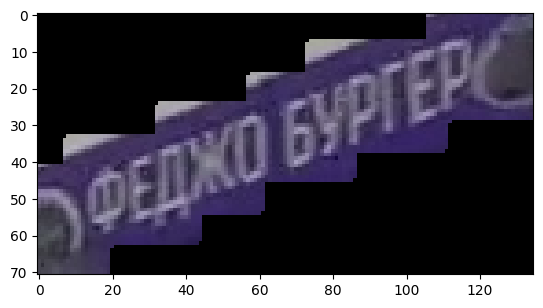

Unfiltered ['БУРТЕРЗ]', 'УФЕДЖО [']


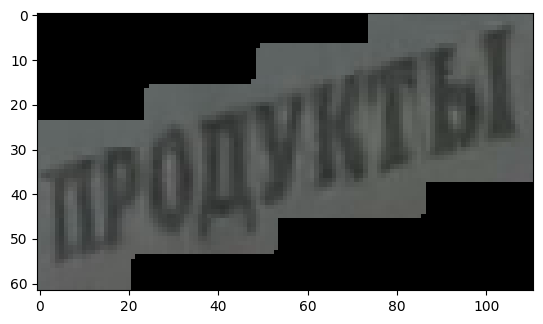

Unfiltered ['ШФДУЮТЫ']


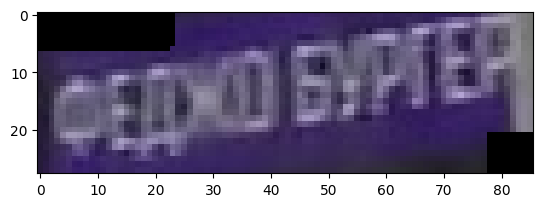

Unfiltered ['ВнН', ',ш']


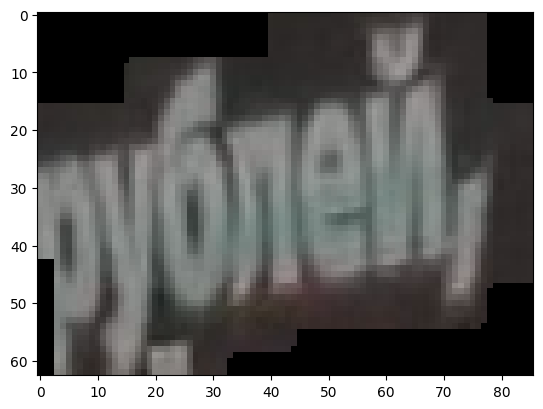

Unfiltered ['[.И']


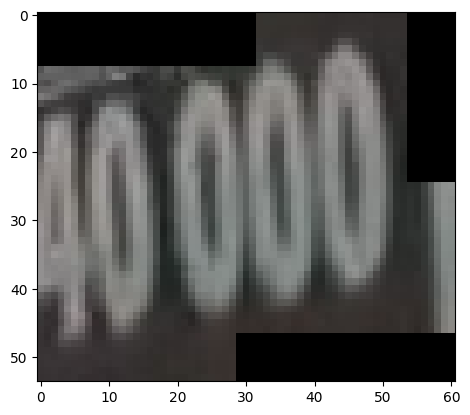

Unfiltered ['Ю']


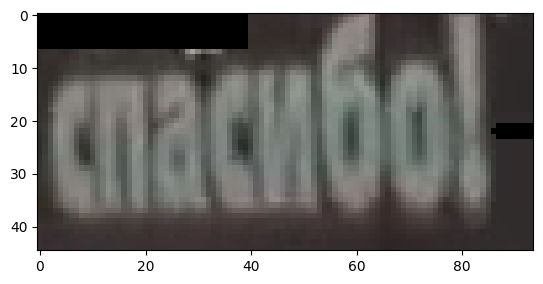

Unfiltered ['ШШП]']


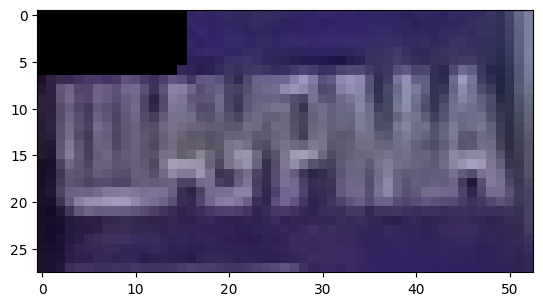

Unfiltered ['Шънн']


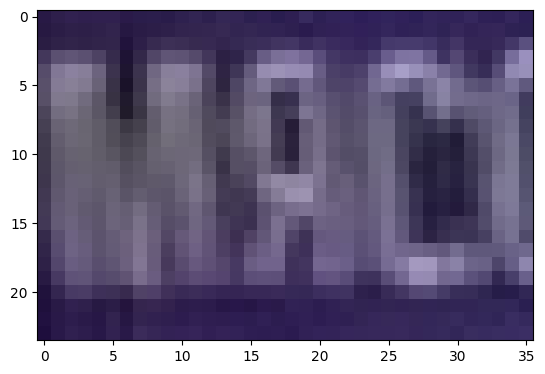

Unfiltered ['4']


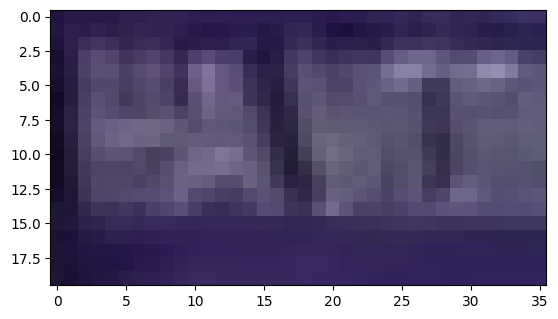

Unfiltered []


In [24]:
# OCR on cropped boxes

def draw(img, boxes):
    for pts in boxes:
        pts = np.array(pts).reshape((-1, 1, 2)).astype(np.int32)
        ## (1) Crop the bounding rect
        rect = cv2.boundingRect(pts)
        x,y,w,h = rect
        croped = img[y:y+h, x:x+w].copy()

        ## (2) make mask
        pts = pts - pts.min(axis=0)

        mask = np.zeros(croped.shape[:2], np.uint8)
        cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

        ## (3) do bit-op
        dst = cv2.bitwise_and(croped, croped, mask=mask)

        # plt.figure(figsize=(10, 10))
        plt.imshow(dst)
        plt.show()

        # text recognition
        print("Unfiltered", reader.readtext(dst, detail=0))
        


# run the function
draw(image, detections[0]['bboxes'])

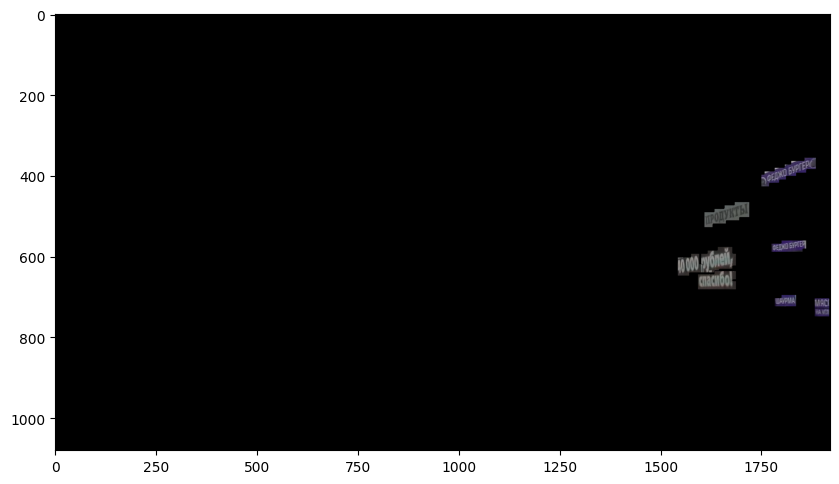

In [26]:
# Masking on cropped boxes

def draw(img, boxes):

    mask = np.full((img.shape[0], img.shape[1]), 0, dtype=np.uint8)

    for pts in boxes:
        mask  = cv2.fillPoly(mask, pts =[np.array(pts).reshape((-1, 1, 2)).astype(np.int32)], color=(255,255,255))

    # get first masked value (foreground)
    masked = cv2.bitwise_and(image, image, mask=mask)

    plt.figure(figsize=(10, 10))
    plt.imshow(masked)
    plt.show()

# run the function
draw(image, detections[0]['bboxes'])

##### Blur the polygon region and paste it on the original image with OCR outputs

In [4]:
from PIL import ImageFont, ImageDraw, Image, ImageEnhance
import os

"""
This function blurs out the polygonal area of the image. The blurred areas are pasted back to the original image with the OCR results.
"""
# read image
image = cv2.imread('yeka.png')

def blur(img_path, boxes, save_path=None):
    # read image
    img = cv2.imread(img_path)
    original = img.copy()
    for pts in boxes:
        pts = np.array(pts).reshape((-1, 1, 2)).astype(np.int32)
        ## (1) Crop the bounding rect
        rect = cv2.boundingRect(pts)
        x,y,w,h = rect
        croped = img[y:y+h, x:x+w].copy()

        ## (2) make mask
        pts = pts - pts.min(axis=0)

        mask = np.zeros(croped.shape[:2], np.uint8)
        cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

        ## (3) do bit-op
        dst = cv2.bitwise_and(croped, croped, mask=mask)

        # plt.imshow(dst)
        # plt.show()

        # text recognition on cropped boxes
        temp_ocr = reader.readtext(dst, detail=0)
        print("Unfiltered", " ".join(temp_ocr))

        # blur the cropped image
        dst = cv2.GaussianBlur(dst,(23, 23), 30)

        # paste the blurred chunk back into the original image
        img[y:y+dst.shape[0], x:x+dst.shape[1]] = dst

        # Draw non-ascii characters onto the image
        font = ImageFont.truetype("arial.ttf", 20)
        
        img_pil = Image.fromarray(img)

        for i in range(len(temp_ocr)):
            if not temp_ocr[i].isascii():
                # resize the text to fit in the blur box
                draw = ImageDraw.Draw(img_pil)
                w, h = draw.textsize(temp_ocr[i], font=font)
                draw.text((x, y+h*i), temp_ocr[i], font=font, fill=(0, 255, 0, 255))
                img = np.array(img_pil)

    # write original and OCR name to bottom of each image 
    cv2.putText(original, "Original", (10, original.shape[0] - 25), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
    cv2.putText(img, "OCR", (10, original.shape[0] - 25), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)


    # combine two images side by side and save the result
    combined = np.concatenate((original, img), axis=1)

    # image name and save path
    name = img_path.split("/")[-1]
    if save_path is None:
        save_path = "results/"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    cv2.imwrite(save_path + name, combined)

# run the function
# blur('yeka.png', detections[0]['bboxes'])

In [6]:
# read the json holding all the OCR results
import json
with open('../final_results.json') as f:
    data = json.load(f)

# show the first result
data[0]

{'filename': 'yeka230116000475.jpg',
 'FastTime': '0.018139123916625977',
 'OCRTime': '0.2352457046508789',
 'FastResults': [{'bboxes': [[1783,
     491,
     1783,
     497,
     1781,
     499,
     1700,
     499,
     1700,
     546,
     1744,
     546,
     1744,
     537,
     1746,
     535,
     1777,
     535,
     1777,
     529,
     1779,
     527,
     1810,
     527,
     1810,
     521,
     1812,
     518,
     1826,
     518,
     1826,
     491],
    [275, 822, 275, 828, 273, 831, 225, 831, 225, 850, 302, 850, 302, 822]],
   'scores': [0.9415658116340637, 0.9129687547683716]}],
 'OCRResults': ['[РОСЛЛСКОМ']}

In [7]:
# run the blur function on all the images using the json file
for i in range(len(data)):
    blur(data[i]['filename'], data[i]['FastResults'][0]['bboxes'], save_path="results/")

Unfiltered КРОСЛекОМ
Unfiltered 
Unfiltered э
Unfiltered 
Unfiltered 
Unfiltered ШОХОЛААНИЦА
Unfiltered 
Unfiltered 500мн
Unfiltered 550 ₽
Unfiltered 
Unfiltered огол;
Unfiltered 
Unfiltered 6 кне 4а
Unfiltered Кс Аша
Unfiltered Въезд
Unfiltered час
Unfiltered 
Unfiltered 
Unfiltered 
Unfiltered 
Unfiltered 
Unfiltered 
Unfiltered улица
Unfiltered БОЛЬШАКОВА
Unfiltered АВТОВОКЗАЛ
Unfiltered ОГИБДД УВД
Unfiltered ИБДД
Unfiltered ГУВД
Unfiltered Свердловской
Unfiltered обл:
Unfiltered Екатеринбурга
Unfiltered Дом-музей Р  ₽ Ва2}о&
Unfiltered П П Бажов
Unfiltered МЯГКОЕ
Unfiltered волото
Unfiltered М1 $ е цщ
Unfiltered меховой
Unfiltered алон
Unfiltered 
Unfiltered 1Й
Unfiltered ШЕ ПЕНИЦЮВ
Unfiltered {ВАЛЬ
Unfiltered Шнийн
Unfiltered НЕРоианеке
Unfiltered МИХЕВА
Unfiltered АЛЛА
Unfiltered 3,08
Unfiltered #н
Unfiltered 
Unfiltered 
Unfiltered 1572ос66] @>$
Unfiltered 80]196:
Unfiltered кантан
Unfiltered 
Unfiltered #юлЯ
Unfiltered Б
Unfiltered [АХЬМШЦАП$ @
Unfiltered [88
Unfiltered 0
Unfil

KeyError: 'filename'